In [1]:
using Pkg
Pkg.activate("..")

using GLMakie, GeometryBasics, LinearAlgebra, FileIO, Random, StatsBase, Rotations

  Activating project at `~/Projects/Working/HIFMB/TempRanges`
[ Info: Precompiling GLMakie [e9467ef8-e4e7-5192-8a1a-b1aee30e663a]


In [161]:
#generate and plot points
N = 500
z = range(0.0,1.0,length = N)        # uniform on [-1, 1]
ϕ = asin.(z)    # uniform on [-pi, pi]
λ = rand(N)

x = (cos.(ϕ) .* cos.(λ))
y = (cos.(ϕ) .* sin.(λ))
z = (sin.(ϕ))
p = Point3f.(x,y,z)

#calculate distance - i -> j
d_mat = zeros(N,N)
ϕ_mat = zeros(N,N)
for i = 1:N
    for j = 1:N
        if i != j
            if ϕ[i] != ϕ[j]
                d_mat[i,j] = acos(sin(ϕ[i]) * sin(ϕ[j]) + cos(ϕ[i]) * cos(ϕ[j]) * cos(abs(λ[i] - λ[j])) )
            else
                d_mat[i,j] = 0.0
            end
        end
        ϕ_mat[i,j] = ϕ[j] - ϕ[i]
    end
end

#weight by distance
c = ϕ .< ϕ' #i < j
w = (π/2 .- d_mat)

#calculate bounds on distances per communtiy
lb = zeros(N)
ub = zeros(N)
for i = 2:N
    d = filter(x -> x > 0, d_mat[i,:] .* c[:,i]) #just non-poleward
    lat = fill(ϕ[i], length(d))
    lb[i] = quantile(d, 0.05)
    ub[i] = quantile(d, 0.95)
end

#number of source coms weighted by distance...
eff_N = [sum(c[:,i] .* w[i,:]) for i = 1:N]
eff_N ./= maximum(eff_N);


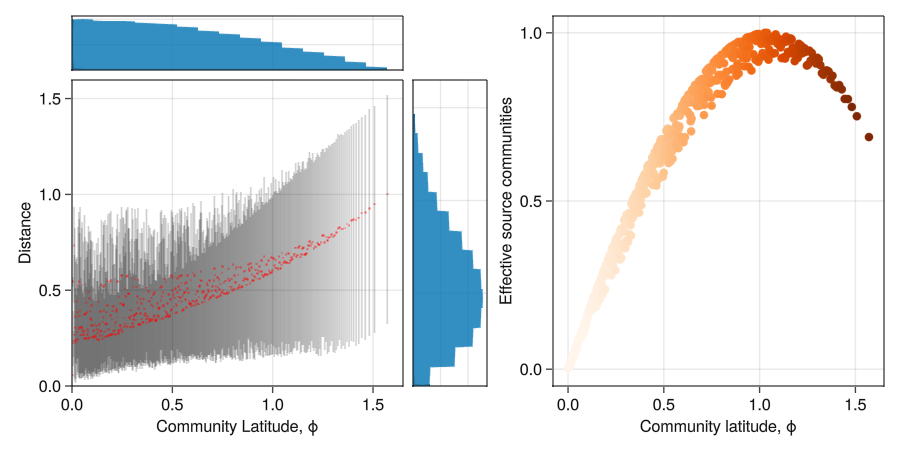

In [166]:
#plot
f = Figure(resolution = (900, 450))
ga = f[1, 1] = GridLayout()

ax1 = Axis(ga[1,1])
ax2 = Axis(ga[2,1], xlabel = "Community Latitude, ϕ", ylabel = "Distance")
ax3 = Axis(ga[2,2])

hist!(ax1, ϕ, normalization = :pdf)
hist!(ax3, filter(x -> x < Inf, d_mat), normalization = :pdf, direction = :x)
rangebars!(ax2, ϕ, lb, ub, color = (:black, 0.2))
[scatter!(ax2, ϕ[i], mean(filter(x -> x > 0, d_mat[i,:] .* c[:,i])), color = :red, markersize = 1.0) for i = 1:N]

[ylims!(f.content[i], low = 0) for i = 1:3]
[xlims!(f.content[i], low = 0) for i = 1:3]

hidedecorations!(ax1, grid = false)
hidedecorations!(ax3, grid = false)




#dplot
ax = Axis(ga[1:2,3], xlabel = "Community latitude, ϕ", ylabel = "Effective source communities")

scatter!(ax, ϕ, eff_N, color = abs.(ϕ), colormap = :Oranges_9)

colgap!(ga, 10)
rowgap!(ga, 10)

colsize!(ga, 1, Relative(0.45))
colsize!(ga, 2, Relative(0.1))
colsize!(ga, 3, Relative(0.45))
rowsize!(ga, 1, Relative(0.15))


f

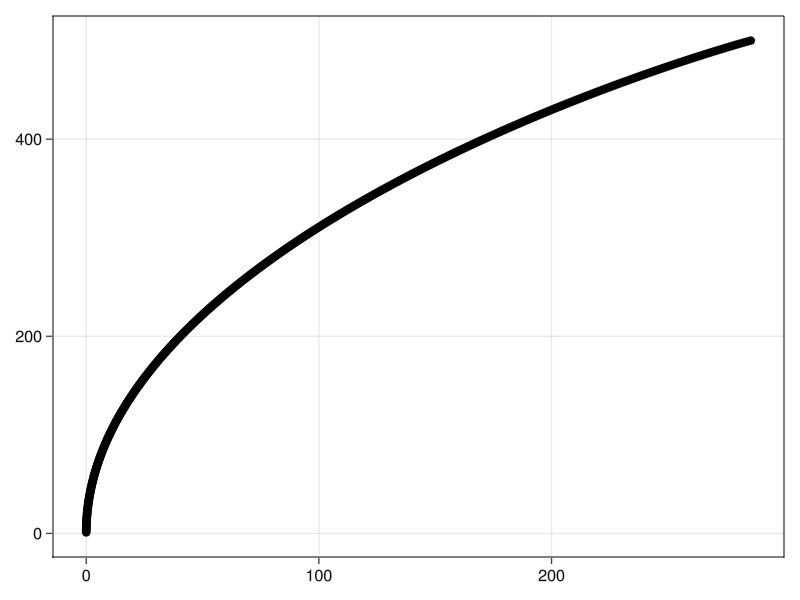

In [169]:
plot(cumsum(ϕ), 1:500)

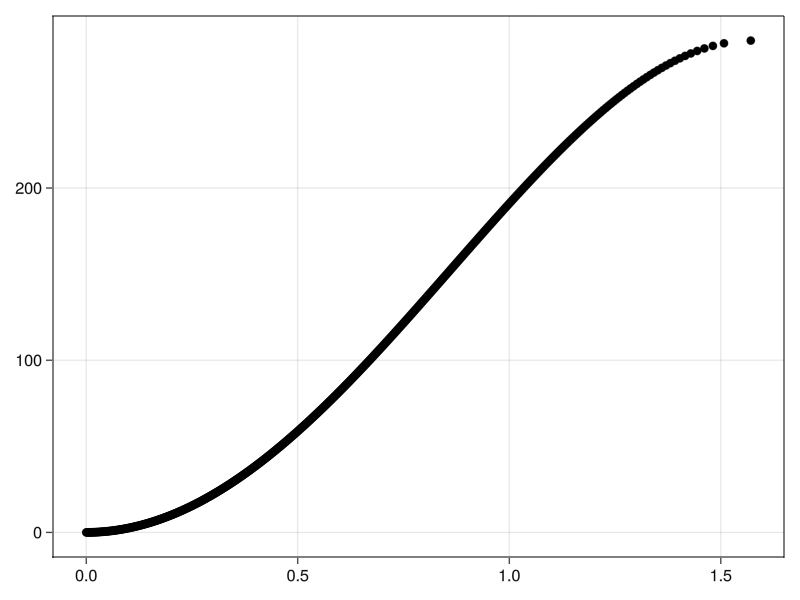

In [175]:
plot(ϕ, cumsum(ϕ))

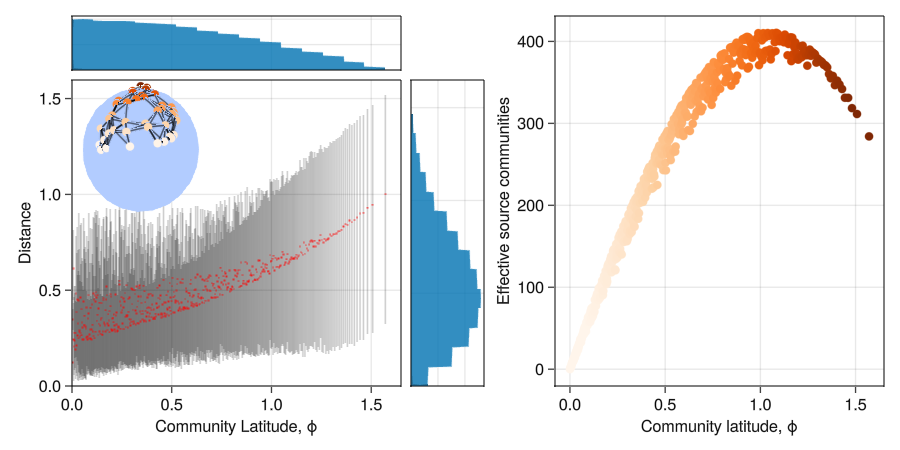

In [144]:
Random.seed!(1)

function arc_coord(p1,p2, d)
    #segement
    S = p1 .+ d.*(p2 .- p1)
    r = 1.01
    u = S ./ norm(S)
    return(r * u)
end

function add_axis_inset(pos=fig[1, 1]; bgcolor=:snow2,
    halign, valign, width=Relative(0.5),height=Relative(0.35),
    alignmode= Mixed(left=5, right=5))
    inset_box = Axis(pos; width, height, halign, valign, alignmode,
        xticklabelsize=12, yticklabelsize=12, backgroundcolor=bgcolor)
    # bring content upfront
    translate!(inset_box.scene, 0, 0, 10)
    return inset_box
end

gb_mesh = Sphere(Point3f(0), 1)

ax = add_axis_inset(ga[2,1], bgcolor=(:white, 0.85), halign=:left, valign=:top, width=Relative(0.42), height=Relative(0.45))
hidespines!(ax)

mesh!(ax, gb_mesh, color = RGBf(0.7,0.8,1.0), shading = false, specular = Vec3f(0.0))

#generate and plot points
N = 40
z = range(0,1,length = N) # uniform on [-1, 1]
ϕ = asin.(z)    # uniform on [-pi, pi]
λ = (π/2)*rand(N)

# ϕ = [0.0, 0.5]
# λ = [π, π + 0.8]
r = 1.02
x = r*(cos.(ϕ) .* cos.(λ))
y = r*(cos.(ϕ) .* sin.(λ))
z = r*(sin.(ϕ))

p = Point3f.(x,y,z)

#rotate points
p = [RotX(-π/2) * p for p = p]
p = [RotY(-π/2 - mean(λ)) * p for p = p]

for i = 1:N
    for j = 1:N
        if ϕ[i] < ϕ[j]
            d = acos(sin(ϕ[i]) * sin(ϕ[j]) + cos(ϕ[i]) * cos(ϕ[j]) * cos(abs(λ[i] - λ[j])) )
            if d < 0.4
                arc_cord_vec = [arc_coord(p[i],p[j], d/21) for d = 0:20]
                cd = (1 - (2d/π))
                c = RGBf(0.0)

                lines!(ax, arc_cord_vec, color = (c, cd^2))
            end
        end
    end
end

scatter!(ax, p, color = abs.(ϕ), colormap = :Oranges_9)

hidedecorations!(ax)

translate!(ax.scene, 0, 0, 10);

f

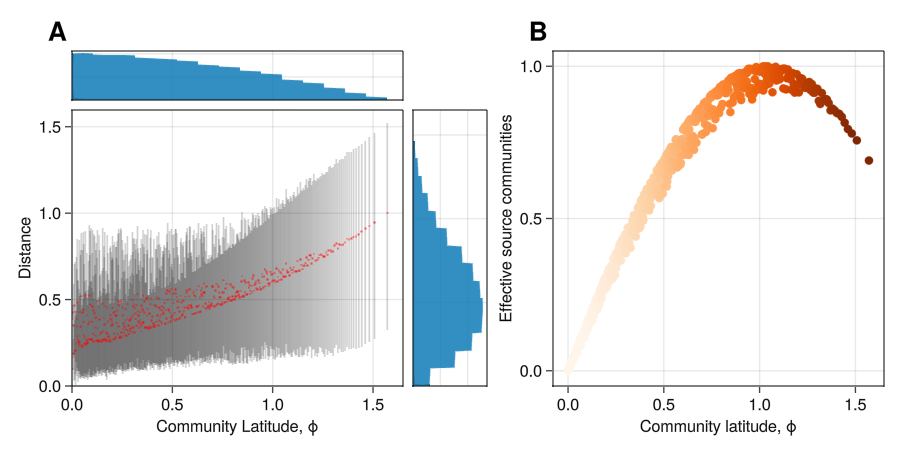

In [4]:
for (label, layout) in zip(["A", "B"], [ga[:,1], ga[:,3]])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 26,
        font = :bold,
        padding = (0, 5, 5, 0),
        halign = :right)
end

f

In [5]:
save("../Figures/fig_geo.png", f)

# Source communities

In [1467]:
#generate and plot points
N = 500
z = range(0.0,1.0,length = N)        # uniform on [-1, 1]
ϕ = asin.(z)    # uniform on [-pi, pi]
λ = rand(N)

x = (cos.(ϕ) .* cos.(λ))
y = (cos.(ϕ) .* sin.(λ))
z = (sin.(ϕ))
p = Point3f.(x,y,z)

d_mat = zeros(N,N)
for i = 1:N
    for j = 1:N
        if i != j
            if ϕ[i] < ϕ[j]
                d_mat[i,j] = acos(sin(ϕ[i]) * sin(ϕ[j]) + cos(ϕ[i]) * cos(ϕ[j]) * cos(abs(λ[i] - λ[j])) )
            else
                d_mat[i,j] = Inf
            end
        end
    end
end



Scatter{Tuple{Vector{Point{2, Float32}}}}

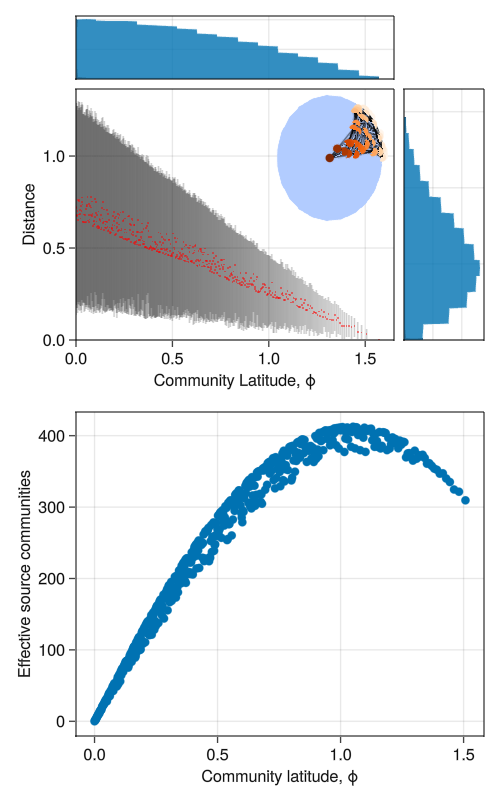

In [1468]:
f

# other plots


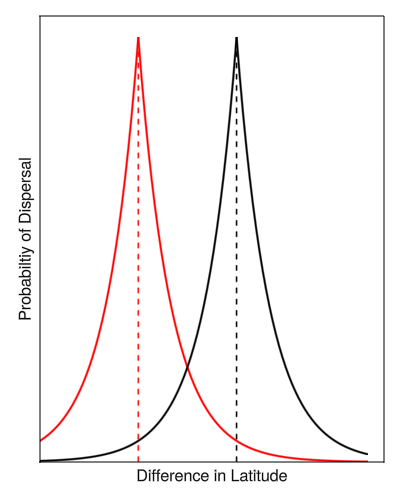

In [130]:
dLat = range(0,1.0, length = 101)

p_d(x, ΔT) = exp(-10abs(x - ΔT))


pd = hcat([p_d.(dLat, t) for t = [0.3,0.6]]...)

fig_pd = Figure(resolution = (400,500))

ax1 = Axis(fig_pd[1,1], xlabel = "Difference in Latitude", ylabel = "Probabiltiy of Dispersal")
series!(ax1, dLat, pd', color = [:red,:black])
vlines!(ax1, [0.3,0.6], linestyle = :dash, ymax = 0.95, ymin = 0.00, color = [:red,:black])

ylims!(ax1, low = 0)
xlims!(ax1, low = 0)
hidedecorations!(ax1, label = false)

fig_pd


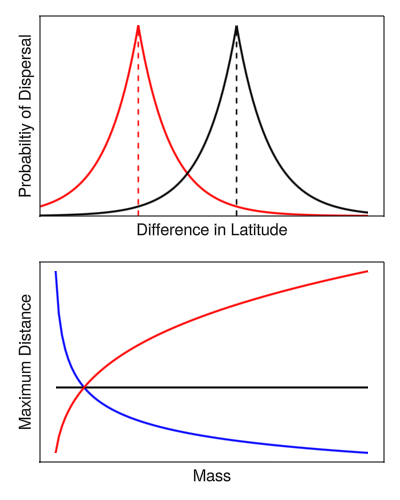

In [131]:
M = range(0.1,10, length = 100)
max_d = [M .^ a for a = [-0.25, 0.0, 0.25]]

ax2 = Axis(fig_pd[2,1], xlabel = "Mass", ylabel = "Maximum Distance")
series!(ax2, hcat(max_d...)', color = [:blue, :black, :red])
hidedecorations!(ax2, label = false)

save("../Figures/eqn_diagram.png", fig_pd)

fig_pd

In [ ]:
save 